In [42]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))


In [43]:
import ee 
import geemap

ee.Initialize(project="ee-india-reservoirs")

In [44]:
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from src.et_blue_per_field.et_blue_field_postprocessing import (
    compute_field_et_stats,
    compute_et_volume,
    threshold_et_volume,
)
from src.et_blue_per_field.etc_look_up_processing import (
    add_date_column,
    compute_et_ratio_timeseries,
    plot_multiple_et_ratio_timeseries,
    create_et_mask,
)

from utils.ee_utils import (
    back_to_float,
    back_to_int,
    export_image_to_asset,
    print_value_ranges,
    is_image_empty,
    fill_gaps_with_zeros,
    export_feature_collection,
)

from utils.date_utils import print_collection_dates, merge_same_date_images

---

## Constants

In [ ]:
YEAR = 2019

ETC_THRESHOLD = 0.65
MINIMUM_IRRIGATION_THRESHOLD = 0

ET_PRODUCT = "Landsat_30m"
# ET_PRODUCT = "WaPOR_10m"


PATH_TO_ET_BLUE_POSTPROCESSED = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_postprocessed/ET_blue_postprocessed_dekadal_from_{ET_PRODUCT}_v2"
PATH_TO_FIELD_BOUNDARIES = (
    f"projects/thurgau-irrigation/assets/FribourgAndVaud/blind_potato_fields"
)
PATH_TO_ET_GREEN = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_green/ET_green_dekadal_from_{ET_PRODUCT}_v2"

PATH_TO_ETF = "projects/thurgau-irrigation/assets/FribourgAndVaud/ETF_Landsat/ETF_Pasture_dekadal_v2"
PATH_TO_ETC_LOOK_UP = (
    f"projects/thurgau-irrigation/assets/FribourgAndVaud/ETc_WAPOR/ETc_Pasture_Broye"
)

Kcs = ee.FeatureCollection('projects/thurgau-irrigation/assets/FribourgAndVaud/ETc_WAPOR/Kc_Pasture_Broye_Aquastat')


TEMPORAL_RESOLUTION = "dekadal"
SCALING_FACTOR = 100
# PATH_TO_POSTPROCESSED_FIELD_LEVEL_ET_BLUE = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field/ET_blue_per_field_{YEAR}_{TEMPORAL_RESOLUTION}_from_{ET_PRODUCT}_ETC_threshold_{int(ETC_THRESHOLD * 100)}"
PATH_TO_POSTPROCESSED_FIELD_LEVEL_ET_BLUE = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_v2/ET_blue_per_field_{YEAR}_{TEMPORAL_RESOLUTION}_from_{ET_PRODUCT}_ETC_threshold_{int(ETC_THRESHOLD * 100)}"

## 0. Load the assets

In [46]:
crop_fields = ee.FeatureCollection(PATH_TO_FIELD_BOUNDARIES)

In [47]:
et_green_collection = (
    ee.ImageCollection(PATH_TO_ET_GREEN)
    .filterDate(f"{YEAR}-01-01", f"{YEAR}-12-31")
    .map(lambda img: back_to_float(img, SCALING_FACTOR))
)

print_collection_dates(et_green_collection)

etf_collection = (
    ee.ImageCollection(PATH_TO_ETF)
    .filterDate(f"{YEAR}-01-01", f"{YEAR}-12-31")
    .map(lambda img: back_to_float(img, SCALING_FACTOR))
)

# print_collection_dates(etf_collection)
# print(etf_collection.first().getInfo())

Dates of images in the collection:
2019-04-01
2019-04-11
2019-04-21
2019-05-01
2019-05-11
2019-05-21
2019-06-01
2019-06-11
2019-06-21
2019-07-01
2019-07-11
2019-07-21
2019-08-01
2019-08-11
2019-08-21
2019-09-01
2019-09-11
2019-09-21
2019-10-01
2019-10-11
2019-10-21


In [48]:
ETc_look_up = ee.FeatureCollection(PATH_TO_ETC_LOOK_UP)

ETc_look_up_df = geemap.ee_to_df(ETc_look_up)

ETc_look_up_df = add_date_column(ETc_look_up_df)

ETc_look_up_df["ETc"] = ETc_look_up_df["ETc"] / 10

ETc_look_up_df = ETc_look_up_df.sort_values(by="Date")

print(ETc_look_up_df.head(12))

          ETc  Month  Year  dekade  Day       Date
0    0.240000      1  2018       1    1 2018-01-01
72   0.240000      1  2018       2   11 2018-01-11
144  0.320000      1  2018       3   21 2018-01-21
1    0.250000      2  2018       1    1 2018-02-01
73   0.333333      2  2018       2   11 2018-02-11
145  0.400000      2  2018       3   21 2018-02-21
2    0.676923      3  2018       1    1 2018-03-01
74   0.761538      3  2018       2   11 2018-03-11
146  1.114286      3  2018       3   21 2018-03-21
3    1.700000      4  2018       1    1 2018-04-01
75   2.550000      4  2018       2   11 2018-04-11
147  2.805000      4  2018       3   21 2018-04-21


In [50]:
et_blue_postprocessed_collection = (
    ee.ImageCollection(PATH_TO_ET_BLUE_POSTPROCESSED)
    .filterDate(f"{YEAR}-01-01", f"{YEAR}-12-31")
    .map(lambda img: back_to_float(img, SCALING_FACTOR))
)

print_collection_dates(et_blue_postprocessed_collection)

Dates of images in the collection:
2019-04-01
2019-04-11
2019-04-21
2019-05-01
2019-05-11
2019-05-21
2019-06-01
2019-06-11
2019-06-21
2019-07-01
2019-07-11
2019-07-21
2019-08-01
2019-08-11
2019-08-21
2019-09-01
2019-09-11
2019-09-21
2019-10-01
2019-10-11
2019-10-21


## 1. Mask ET blue pixels where ET green > X * ET<sub>c</sub>

In [ ]:
#WAPOR
masked_collection = et_green_collection.map(lambda img: create_et_mask(img, ETc_look_up_df, "ET_green", ETC_THRESHOLD))
print(masked_collection.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'ET_green', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 1}, 'dimensions': [1963, 2387], 'crs': 'EPSG:32632', 'crs_transform': [10, 0, 327440, 0, -10, 5195720]}], 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[6.743775905774364, 46.67791279248287], [6.74379230131995, 46.67791241686437], [7.000159954652322, 46.68268240154832], [7.000219018288402, 46.6827200237579], [7.000284417647323, 46.682752222712836], [7.000287991453084, 46.68276710852673], [6.992321048706773, 46.89736155309526], [6.992266071471521, 46.897402096941775], [6.992218820269509, 46.897447001422414], [6.99220258585266, 46.89744881274416], [6.992186096673732, 46.89744922681749], [6.734798212460734, 46.89264354279371], [6.734739148440174, 46.89260577097019], [6.734673588281716, 46.89257336178387], [6.734670083481858, 46.89255855419111], [6.743657449128487, 46.67799978995011], [6.743712500643442, 46.67795938716433], [6.7437596658226315, 

In [51]:
#LANDSAT

def create_etc_mask(
    image: ee.Image,
    band_name: str,
    threshold: float,
    kcs_collection: ee.FeatureCollection,
) -> ee.Image:
    """
    Create a mask for the input image by dividing the band values by the corresponding Kc
    and applying the threshold.

    Args:
        image: The input Earth Engine image.
        band_name: The name of the band to process.
        threshold: The threshold to apply for masking.
        kcs_collection: The FeatureCollection containing Kc values.

    Returns:
        ee.Image: A masked image.
    """
    # Extract the date from the image properties
    sensing_date = ee.Date(image.get("system:time_start"))
    month = sensing_date.get("month")
    decade = sensing_date.get("day").divide(10).ceil()

    # Retrieve the corresponding Kc value from the Kcs FeatureCollection
    kc_feature = Kcs.filter(
        ee.Filter.And(
            ee.Filter.eq("Month", month),
            ee.Filter.eq("Decade", decade)
        )
    ).first()
    kc = ee.Number(kc_feature.get("Kc"))

    # Divide the band by Kc and create the mask
    band = image.select(band_name)
    divided_band = band.divide(kc)
    mask = divided_band.lte(threshold)

    # Return the masked image
    return mask

# Example usage
masked_collection = etf_collection.map(
    lambda img: create_etc_mask(img, "ET_green", ETC_THRESHOLD, Kcs)
)
print(masked_collection.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'ET_green', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 1}, 'dimensions': [930, 808], 'crs': 'EPSG:4326', 'crs_transform': [0.00026949458523585647, 0, 6.742754522601129, 0, -0.00026949458523585647, 46.89690873357327]}], 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[6.742840057232417, 46.679024024339206], [6.742889625316077, 46.679021913253315], [6.868069477481089, 46.679021903923434], [6.993249456148091, 46.67902188670316], [6.9934309890054625, 46.679131526520244], [6.993630903363245, 46.67922486315247], [6.993643191711947, 46.679269125531064], [6.993644857864228, 46.89677400656246], [6.99348432158734, 46.8968983443086], [6.993348045768766, 46.897035474338296], [6.993283046434918, 46.89704391376309], [6.868069474556865, 46.89704398200757], [6.742888961939994, 46.8970439534848], [6.742707147834236, 46.89693418183033], [6.74250657592446, 46.896840978074266], [6.742494185544892, 46.89679651374745],

In [52]:
def multiply_image_collections(
    col1: ee.ImageCollection, col2: ee.ImageCollection, band_name1: str, band_name2: str
) -> ee.ImageCollection:
    """
    Multiply images from two collections with matching dates for a specified band.

    Args:
        col1: First image collection
        col2: Second image collection
        band_name1: Band name from first collection to multiply
        band_name2: Band name from second collection to multiply

    Returns:
        Image collection containing the multiplied results
    """
    # Sort both collections by date
    sorted_col1 = col1.sort("system:time_start")
    sorted_col2 = col2.sort("system:time_start")

    # Convert to lists for paired iteration
    col_list1 = sorted_col1.toList(sorted_col1.size())
    col_list2 = sorted_col2.toList(sorted_col2.size())

    def multiply_images(index):
        # Get corresponding images
        img1 = ee.Image(col_list1.get(index))
        img2 = ee.Image(col_list2.get(index))

        # Multiply the specified bands
        result = img1.select(band_name1).multiply(img2.select(band_name2))

        # Return result with the timestamp from first collection
        return result.copyProperties(img1, ["system:time_start"])

    # Create sequence for mapping
    sequence = ee.List.sequence(0, sorted_col1.size().subtract(1))

    # Map multiplication over the sequences
    return ee.ImageCollection(sequence.map(multiply_images))

In [53]:
et_blue_masked = multiply_image_collections(et_blue_postprocessed_collection, masked_collection, "ET_blue", "ET_green")
et_blue_masked_list = et_blue_masked.toList(et_blue_masked.size())

## 2. Compute ET blue statistics per field

In [54]:
def count_empty_images_per_month(feature):
    properties = feature.propertyNames().filter(
        ee.Filter.stringContains("item", "median_et_blue")
    )

    def count_empty_by_month(current_month, prev_feature):
        month_str = ee.Number(current_month).format("%02d")
        month_props = properties.filter(ee.Filter.stringContains("item", month_str))

        empty_count = month_props.map(
            lambda prop: ee.Number(
                ee.Algorithms.If(ee.Number(feature.get(prop)).eq(-99), 1, 0)
            )
        ).reduce(ee.Reducer.sum())

        prop_name = ee.String("empty_images_month_").cat(month_str)
        return ee.Feature(prev_feature).set(prop_name, empty_count)

    months = ee.List.sequence(4, 10)
    return months.iterate(count_empty_by_month, feature)


In [58]:
dates = et_blue_masked.aggregate_array("system:time_start")

dates = [ee.Date(date).format("YYYY-MM-dd").getInfo() for date in dates.getInfo()]


crop_fields_iteration = crop_fields

crop_fields_iteration = crop_fields_iteration.map(
    lambda f: f.set(
        {
            "etc_threshold": ETC_THRESHOLD,
        }
    )
)

for i, date in enumerate(dates):

    image = ee.Image(et_blue_masked_list.get(i))

    fileds_with_stats = compute_field_et_stats(
        et_image=image,
        fields=crop_fields_iteration,
        et_band_name="ET_blue",
        scale=10,
        date=date,
    )

    feature_with_m3 = compute_et_volume(fileds_with_stats, date=date)

    feature_with_m3 = threshold_et_volume(
        feature_with_m3, threshold=MINIMUM_IRRIGATION_THRESHOLD, date=date
    )

    crop_fields_iteration = feature_with_m3


updated_features = crop_fields_iteration.map(count_empty_images_per_month)

task_name = f"field_et_blue_{ET_PRODUCT}_ETC_{ETC_THRESHOLD}_{YEAR}"

export_feature_collection(
    collection=updated_features,
    task_name=task_name,
    asset_id=PATH_TO_POSTPROCESSED_FIELD_LEVEL_ET_BLUE,
)

# updated_features.getInfo()

In [ ]:
dates = et_blue_masked.aggregate_array("system:time_start")

dates = [ee.Date(date).format("YYYY-MM-dd").getInfo() for date in dates.getInfo()]


crop_fields_iteration = crop_fields

crop_fields_iteration = crop_fields_iteration.map(
    lambda f: f.set(
        {
            "etc_threshold": ETC_THRESHOLD,
        }
    )
)

for i, date in enumerate(dates[9:12]):

    image = ee.Image(et_blue_masked_list.get(i))

    ##maybe change to compute median_et_blue also where zero fraction is higher than 0.5, and then only remove values if there is no time step with 
    ##median_et_blue>0 and zero_fraction<0.5
    fileds_with_stats = compute_field_et_stats(
        et_image=image,
        fields=crop_fields_iteration,
        et_band_name="ET_blue",
        scale=10,
        date=date,
    )

    feature_with_m3 = compute_et_volume(fileds_with_stats, date=date)

    feature_with_m3 = threshold_et_volume(
        feature_with_m3, threshold=MINIMUM_IRRIGATION_THRESHOLD, date=date
    )

    crop_fields_iteration = feature_with_m3

print('crop_fields_iteration',crop_fields_iteration.first().getInfo())

crop_fields_iteration {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[6.898340787574285, 46.82566675554755], [6.898380968295865, 46.82564443232396], [6.8985682164940565, 46.8256488679297], [6.898871397517888, 46.82567117592232], [6.900851242980219, 46.828560704623655], [6.900837916119662, 46.828565147649975], [6.900360784718916, 46.82873013401383], [6.900307299635416, 46.82870782203597], [6.899303962420583, 46.82718283774913], [6.898345301063176, 46.825706872132194], [6.898340787574285, 46.82566675554755]]]}, 'id': '00000000000000000000', 'properties': {'ID': '18-1-510429', 'Jahr': 18, 'Kultur': 'Kartoffeln', 'et_blue_m3_2019-07-01': 0, 'et_blue_m3_2019-07-11': 0, 'et_blue_m3_2019-07-21': 0, 'etc_threshold': 0.65, 'median_et_blue_2019-07-01': 0, 'median_et_blue_2019-07-11': 0, 'median_et_blue_2019-07-21': -99, 'xkoord': 2558887.733, 'ykoord': 1186364.763, 'zero_fraction_2019-07-01': 1, 'zero_fraction_2019-07-11': 1, 'zero_fraction_2019-07-21': 0}}


---

In [78]:
print(dates[9:12])

['2019-07-01', '2019-07-11', '2019-07-21']


In [68]:
Map = geemap.Map()

et_blue_list = et_blue_masked.toList(et_blue_masked.size())
et_blue = ee.Image(et_blue_list.get(9))
print(ee.Date(et_blue.get('system:time_start')).format('YYYY-MM-dd').getInfo())
vis_params = {"bands": ["ET_blue"], "min": 0, "max": 1, "palette": "viridis"}

Map.addLayer(et_blue, vis_params, "ET_blue")

Map.addLayer(crop_fields_iteration, {"color": "red"}, "fields_with_stats")

Map.centerObject(crop_fields, 12)


Map

2019-07-01


Map(center=[46.81340138134065, 6.909127982292969], controls=(WidgetControl(options=['position', 'transparent_b…

---

In [60]:
etc_table = ee.FeatureCollection("projects/thurgau-irrigation/assets/FribourgAndVaud/ETc_WAPOR/ETc_Pasture_Broye")

etc_df = geemap.ee_to_df(etc_table)

etc_df = add_date_column(etc_df)

etc_df["ETc"] = etc_df["ETc"]/10

print(etc_df.tail(12))


          ETc  Month  Year  dekade  Day       Date
204  0.160000      1  2023       3   21 2023-01-21
205  0.720000      2  2023       3   21 2023-02-21
206  1.200000      3  2023       3   21 2023-03-21
207  1.955000      4  2023       3   21 2023-04-21
208  3.275862      5  2023       3   21 2023-05-21
209  4.000000      6  2023       3   21 2023-06-21
210  4.079487      7  2023       3   21 2023-07-21
211  2.724242      8  2023       3   21 2023-08-21
212  2.095238      9  2023       3   21 2023-09-21
213  0.900000     10  2023       3   21 2023-10-21
214  0.300000     11  2023       3   21 2023-11-21
215  0.240000     12  2023       3   21 2023-12-21


In [61]:
et_green_collection1 = ee.ImageCollection(
    "projects/thurgau-irrigation/assets/FribourgAndVaud/ET_green/ET_green_dekadal_from_Landsat_30m_v2"
).map(lambda img: back_to_float(img, SCALING_FACTOR))

etf_collection = ee.ImageCollection(PATH_TO_ETF).map(lambda img: back_to_float(img, SCALING_FACTOR))

et_green_collection2 = ee.ImageCollection(
    "projects/thurgau-irrigation/assets/FribourgAndVaud/ET_green/ET_green_dekadal_from_WaPOR_10m_v2"
).map(lambda img: back_to_float(img, SCALING_FACTOR))

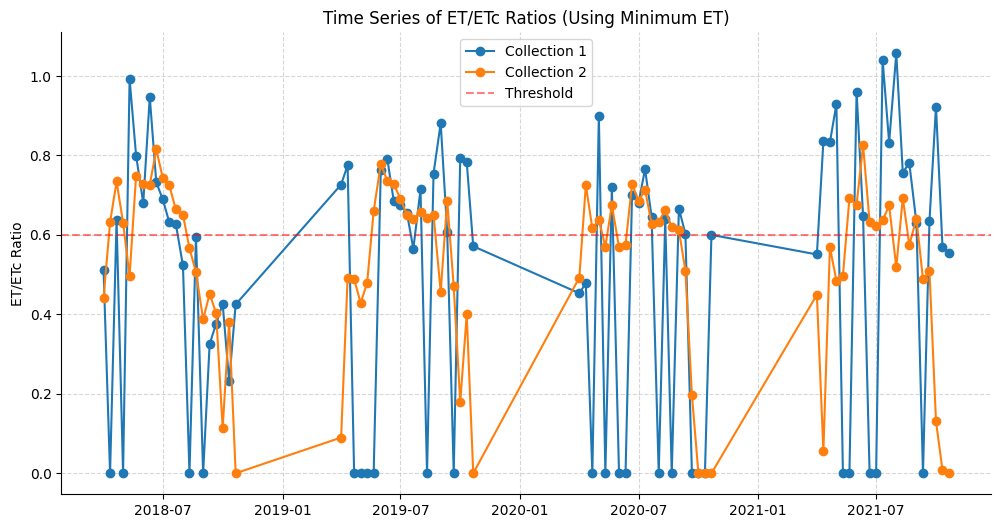

In [62]:
ratio_df1 = compute_et_ratio_timeseries(
    et_collections=[et_green_collection1, et_green_collection2],# ,
    etc_df=etc_df,
    et_band_name="ET_green"
)

# Plot the results
plot_multiple_et_ratio_timeseries(ratio_df1)


ratio_df1 = compute_et_ratio_timeseries(
    et_collections=[et_green_collection2],#et_green_collection1 ,
    etc_df=etc_df,
    et_band_name="ET_green"
)

# Plot the results
# plot_multiple_et_ratio_timeseries(ratio_df)

# You can also examine the raw data
# print(ratio_df.head(36))

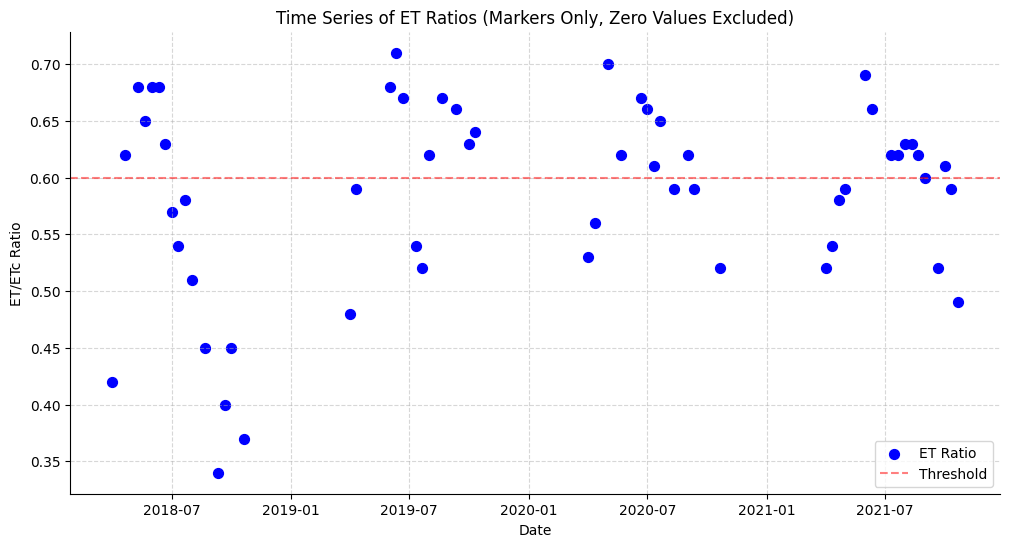

          date  min_et_1  etf_1
0   2018-04-01      0.42   0.42
1   2018-04-11      0.00   0.00
2   2018-04-21      0.62   0.62
3   2018-05-01      0.00   0.00
4   2018-05-11      0.68   0.68
5   2018-05-21      0.65   0.65
6   2018-06-01      0.68   0.68
7   2018-06-11      0.68   0.68
8   2018-06-21      0.63   0.63
9   2018-07-01      0.57   0.57
10  2018-07-11      0.54   0.54
11  2018-07-21      0.58   0.58
12  2018-08-01      0.51   0.51
13  2018-08-11      0.00   0.00
14  2018-08-21      0.45   0.45
15  2018-09-01      0.00   0.00
16  2018-09-11      0.34   0.34
17  2018-09-21      0.40   0.40
18  2018-10-01      0.45   0.45
19  2018-10-11      0.00   0.00
20  2018-10-21      0.37   0.37
21  2019-04-01      0.48   0.48
22  2019-04-11      0.59   0.59
23  2019-04-21      0.00   0.00
24  2019-05-01      0.00   0.00
25  2019-05-11      0.00   0.00
26  2019-05-21      0.00   0.00
27  2019-06-01      0.68   0.68
28  2019-06-11      0.71   0.71
29  2019-06-21      0.67   0.67
30  2019

In [63]:
ratio_df = compute_et_ratio_timeseries(
    et_collections=[et_green_collection1 ,et_green_collection2],
    etc_df=etc_df,
    et_band_name="ET_green"
)


import pandas as pd
import ee
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Optional, Union, Tuple
import numpy as np

def compute_etf_timeseries(
    etf_collections: List[ee.ImageCollection], etf_band_name: str = "ETF"
) -> pd.DataFrame:
    """Compute time series for ETF (ET ratio) from input collections.

    Args:
        etf_collections: List of ETF image collections to process.
        etf_band_name: Name of the ETF band in the images.

    Returns:
        DataFrame with columns for date and ETF statistics for each collection.
    """
    # Process each collection
    all_results = []
    for idx, collection in enumerate(etf_collections):
        results = (
            collection.map(
                lambda img: _process_single_etf_image(img, idx, etf_band_name)
            )
            .sort("date")
            .toList(collection.size())
        )
        all_results.append(results.getInfo())

    # Combine results into DataFrame
    data = []
    for time_idx in range(len(all_results[0])):
        combined_props = {}
        date_str = all_results[0][time_idx]["properties"]["date"]
        combined_props["date"] = datetime.strptime(date_str, "%Y-%m-%d").date()

        for collection_idx in range(len(etf_collections)):
            props = all_results[collection_idx][time_idx]["properties"]
            for key in [f"min_et_{collection_idx+1}", f"etf_{collection_idx+1}"]:
                combined_props[key] = props.get(key)

        data.append(combined_props)

    return pd.DataFrame(data).sort_values("date")


def _process_single_etf_image(
    image: ee.Image, collection_idx: int, etf_band_name: str = "ETF"
) -> ee.Feature:
    """Process a single image and compute ETF statistics.

    Handles empty/masked images by returning null values for statistics.

    Args:
        image: Input ETF image.
        collection_idx: Index of current collection (1-based for output naming).
        etf_band_name: Name of the ETF band in the image.

    Returns:
        Feature containing date, min_et, and ETF properties.
    """
    image_date = ee.Date(image.get("system:time_start"))

    # Check if image has any valid pixels
    valid_pixels = image.select(etf_band_name).unmask(None)
    valid_count = (
        valid_pixels.multiply(0)
        .add(1)
        .reduceRegion(reducer=ee.Reducer.count(), maxPixels=int(1e9))
        .get(etf_band_name)
    )

    def compute_stats() -> ee.Feature:
        # Get minimum ETF value
        min_etf = ee.Number(
            valid_pixels.reduceRegion(
                reducer=ee.Reducer.median(), maxPixels=int(1e9)
            ).get(etf_band_name)
        )

        return ee.Feature(
            None,
            {
                "date": image_date.format("YYYY-MM-dd"),
                "Month": image_date.get("month"),
                "Decade": image_date.get("day").divide(10).ceil(),
                f"min_et_{collection_idx+1}": min_etf,
                f"etf_{collection_idx+1}": min_etf,  # Assuming this is the ETF value
            },
        )

    def empty_feature() -> ee.Feature:
        return ee.Feature(
            None,
            {
                "date": image_date.format("YYYY-MM-dd"),
                f"min_et_{collection_idx+1}": None,
                f"etf_{collection_idx+1}": None,
            },
        )

    return ee.Algorithms.If(
        ee.Number(valid_count).gt(0), compute_stats(), empty_feature()
    )

import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_et_ratio_markers_no_zeros(df: pd.DataFrame) -> None:
    """Plot ET ratio time series for a single collection using markers only, excluding zero values.

    Args:
        df: DataFrame containing a single ET ratio column (etf_1 or et_ratio_1).
    """
    # Identify the ratio column
    ratio_column = next(col for col in df.columns if col.startswith("etf_") or col.startswith("et_ratio_"))

    # Filter out zero values
    filtered_df = df[df[ratio_column] > 0]

    # Reset styles to avoid unintended global settings
    sns.reset_orig()

    # Plot only markers
    plt.figure(figsize=(12, 6))
    plt.scatter(filtered_df["date"], filtered_df[ratio_column], label="ET Ratio", color="blue", s=50)

    # Add threshold line
    plt.axhline(y=0.6, color="r", linestyle="--", alpha=0.5, label="Threshold")

    # Set plot details
    plt.title("Time Series of ET Ratios (Markers Only, Zero Values Excluded)")
    plt.xlabel("Date")
    plt.ylabel("ET/ETc Ratio")
    plt.legend(loc="lower right")  # Set legend position to lower right
    plt.grid(True, linestyle="--", alpha=0.5)
    sns.despine()
    plt.show()


# ratio_df = compute_et_ratio_timeseries(
#     et_collections=[et_green_collection1 ,et_green_collection2],
#     etc_df=etc_df,
#     et_band_name="ET_green"
# )
ratio_df = compute_etf_timeseries([etf_collection], etf_band_name="ET_green")


# Plot the results
plot_single_et_ratio_markers_no_zeros(ratio_df)

# You can also examine the raw data
print(ratio_df.head(36))

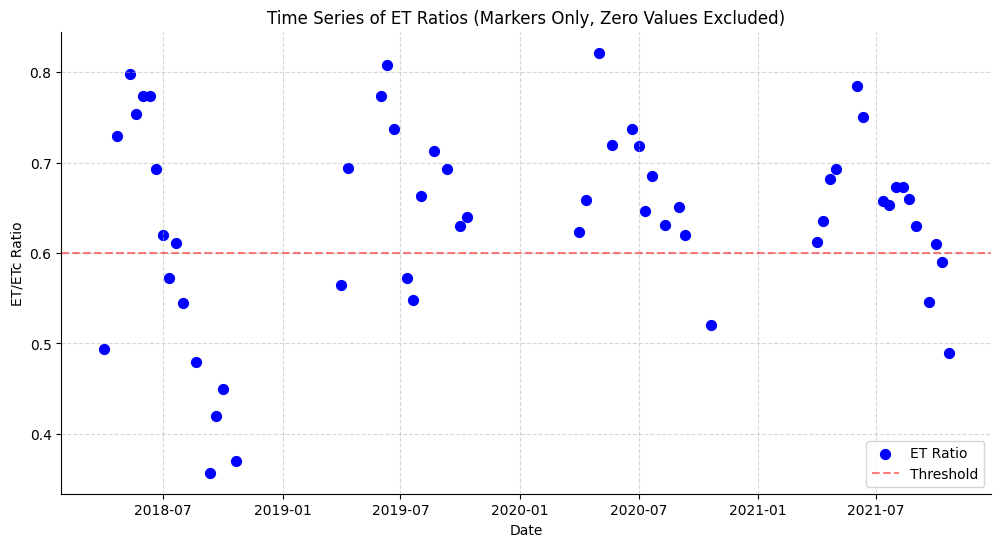

         date  min_et_1     etf_1  Month  Day  Decade        Kc
0  2018-04-01      0.42  0.494118      4    1       1  0.850000
1  2018-04-11      0.00  0.000000      4   11       2  0.850000
2  2018-04-21      0.62  0.729412      4   21       3  0.850000
3  2018-05-01      0.00  0.000000      5    1       1  0.851852
4  2018-05-11      0.68  0.798261      5   11       2  0.851852
..        ...       ...       ...    ...  ...     ...       ...
79 2021-09-11      0.00  0.000000      9   11       2  0.952381
80 2021-09-21      0.52  0.546000      9   21       3  0.952381
81 2021-10-01      0.61  0.610000     10    1       1  1.000000
82 2021-10-11      0.59  0.590000     10   11       2  1.000000
83 2021-10-21      0.49  0.490000     10   21       3  1.000000

[84 rows x 7 columns]


In [64]:
import pandas as pd
import numpy as np

# First table
df1 = ratio_df

# Second table
df2 = Kcs

# Ensure "date" column is datetime
df1["date"] = pd.to_datetime(df1["date"])

# Extract Month and Decade from date
df1["Month"] = df1["date"].dt.month
df1["Day"] = df1["date"].dt.day
df1["Decade"] = np.ceil(df1["Day"] / 10).astype(int)

# Function to get Kc from the GEE FeatureCollection
def get_kc(month, decade):
    feature = df2.filter(ee.Filter.And(
        ee.Filter.eq("Month", month),
        ee.Filter.eq("Decade", decade)
    )).first()
    return ee.Number(feature.get("Kc")).getInfo() if feature else None

# Add Kc and ETc to the DataFrame
df1["Kc"] = df1.apply(lambda row: get_kc(row["Month"], row["Decade"]), axis=1)
df1["etf_1"] = df1["etf_1"] / df1["Kc"]

# Plot the results
plot_single_et_ratio_markers_no_zeros(df1)

# Display the resulting DataFrame
print(df1)

ratio_df1_Landsat = df1



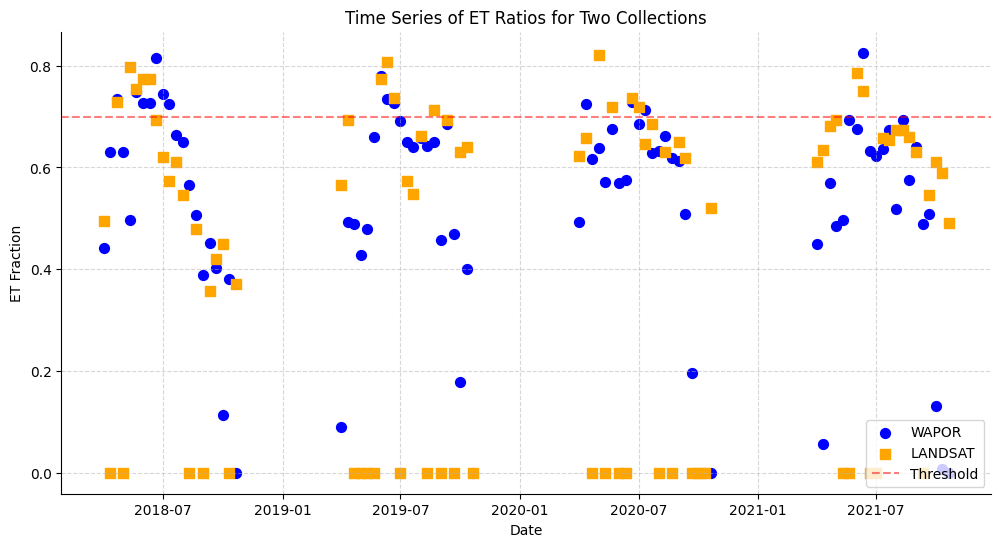

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Tuple

def plot_dual_et_ratio_markers(
    df1: pd.DataFrame, df2: pd.DataFrame, labels: Tuple[str, str] = ("Collection 1", "Collection 2")
) -> None:
    """Plot ET ratio time series for two collections using markers only.

    Args:
        df1: DataFrame for the first image collection.
        df2: DataFrame for the second image collection.
        labels: Tuple of labels for the two collections.
    """
    # Identify the ratio columns in each DataFrame
    ratio_col1 = next(col for col in df1.columns if col.startswith("etf_") or col.startswith("et_ratio_"))
    ratio_col2 = next(col for col in df2.columns if col.startswith("etf_") or col.startswith("et_ratio_"))

    # Reset styles to avoid unintended global settings
    sns.reset_orig()

    # Plot
    plt.figure(figsize=(12, 6))

    # Plot first collection with markers
    plt.scatter(df1["date"], df1[ratio_col1], label=labels[0], color="blue", s=50, marker="o")

    # Plot second collection with markers
    plt.scatter(df2["date"], df2[ratio_col2], label=labels[1], color="orange", s=50, marker="s")

    # Add threshold line
    plt.axhline(y=0.7, color="r", linestyle="--", alpha=0.5, label="Threshold")

    # Set plot details
    plt.title("Time Series of ET Ratios for Two Collections")
    plt.xlabel("Date")
    plt.ylabel("ET Fraction")
    plt.legend(loc="lower right")  # Legend in the lower-right corner
    plt.grid(True, linestyle="--", alpha=0.5)
    sns.despine()
    plt.show()



# Plot the ET ratio time series
# plot_dual_et_ratio_markers(ratio_df1, ratio_df, labels=("WAPOR", "LANDSAT"))
plot_dual_et_ratio_markers(ratio_df1, ratio_df1_Landsat, labels=("WAPOR", "LANDSAT"))

In [66]:
print(ratio_df1.head(99))

print(ratio_df1_Landsat.head(99))



          date  min_et_1       etc  et_ratio_1
0   2018-04-01      0.75  1.700000    0.441176
1   2018-04-11      1.61  2.550000    0.631373
2   2018-04-21      2.06  2.805000    0.734403
3   2018-05-01      1.29  2.044444    0.630978
4   2018-05-11      1.10  2.214815    0.496656
..         ...       ...       ...         ...
79  2021-09-11      0.93  1.904762    0.488250
80  2021-09-21      0.92  1.809524    0.508421
81  2021-10-01      0.17  1.300000    0.130769
82  2021-10-11      0.01  1.300000    0.007692
83  2021-10-21      0.00  0.900000    0.000000

[84 rows x 4 columns]
         date  min_et_1     etf_1  Month  Day  Decade        Kc
0  2018-04-01      0.42  0.494118      4    1       1  0.850000
1  2018-04-11      0.00  0.000000      4   11       2  0.850000
2  2018-04-21      0.62  0.729412      4   21       3  0.850000
3  2018-05-01      0.00  0.000000      5    1       1  0.851852
4  2018-05-11      0.68  0.798261      5   11       2  0.851852
..        ...       ...      

In [67]:
import pandas as pd

def calculate_annual_average(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate annual averages of ET ratios for two collections,
    considering only dates where ET ratio for the second collection (df2) is not zero.

    Args:
        df1: DataFrame for the first image collection.
        df2: DataFrame for the second image collection.

    Returns:
        pd.DataFrame: Annual average ET ratios for both collections.
    """
    # Set the column names explicitly
    ratio_col1 = "et_ratio_1"  # ET ratio column for the first collection
    ratio_col2 = "etf_1"       # ET ratio column for the second collection

    # Filter the second dataset (df2) for non-zero ET ratios
    df2_filtered = df2[df2[ratio_col2] > 0.2].copy()
    df1_filtered = df1[df1[ratio_col1] > 0.2].copy()

    # Align the first dataset (df1) to match dates in df2_filtered
    df1_filtered = df1_filtered[df1_filtered["date"].isin(df2_filtered["date"])].copy()
    df2_filtered = df2_filtered[df2_filtered["date"].isin(df1_filtered["date"])].copy()

    # Extract years from the date columns
    df1_filtered["year"] = pd.to_datetime(df1_filtered["date"]).dt.year
    df2_filtered["year"] = pd.to_datetime(df2_filtered["date"]).dt.year

    # Rename columns before merging to enforce suffixes
    df1_filtered.rename(columns={ratio_col1: f"{ratio_col1}_collection1"}, inplace=True)
    df2_filtered.rename(columns={ratio_col2: f"{ratio_col2}_collection2"}, inplace=True)

    # Merge the filtered data on dates
    merged = pd.merge(
        df1_filtered,
        df2_filtered,
        on="date"  # Merge only on the date column
    )

    # Calculate annual averages
    merged["year"] = pd.to_datetime(merged["date"]).dt.year
    annual_avg = (
        merged.groupby("year")[[f"{ratio_col1}_collection1", f"{ratio_col2}_collection2"]]
        .mean()
        .reset_index()
    )

    # Rename columns for clarity
    annual_avg.rename(columns={f"{ratio_col1}_collection1": "avg_et_collection1",
                               f"{ratio_col2}_collection2": "avg_et_collection2"}, inplace=True)

    return annual_avg


# Example usage
df1 = ratio_df1

# pd.DataFrame({
#     "date": ["2018-04-01", "2018-04-11", "2018-04-21", "2018-05-01", "2018-05-11", "2018-05-21"],
#     "min_et_1": [0.74, 1.60, 2.02, 1.26, 1.05, 2.31],
#     "etc": [1.7, 2.55, 2.805, 2.044444, 2.214815, 3.189655],
#     "et_ratio_1": [0.435294, 0.627451, 0.720143, 0.616304, 0.474080, 0.724216]
# })

df2 = ratio_df1_Landsat
# pd.DataFrame({
#     "date": ["2018-04-01", "2018-04-11", "2018-04-21", "2018-05-01", "2018-05-11", "2018-05-21"],
#     "min_et_1": [0.39, 0.0, 0.58, 0.0, 0.61, 0.56],
#     "etf_1": [0.39, 0.0, 0.58, 0.0, 0.61, 0.56]
# })

# Ensure "date" columns are in datetime format
df1["date"] = pd.to_datetime(df1["date"])
df2["date"] = pd.to_datetime(df2["date"])

# Calculate annual averages
annual_averages = calculate_annual_average(df1, df2)
print(annual_averages)


   year  avg_et_collection1  avg_et_collection2
0  2018            0.630868            0.615854
1  2019            0.641833            0.684266
2  2020            0.642629            0.682893
3  2021            0.604279            0.668077


## Sanity check

In [71]:
YEAR = 2019
ET_PRODUCT = "Landsat_30m"
# ET_PRODUCT = "WaPOR_10m"


PATH_TO_FEATURE_COLLECTION = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_v2/ET_blue_per_field_{YEAR}_dekadal_from_{ET_PRODUCT}_ETC_threshold_65"
print(PATH_TO_FEATURE_COLLECTION)
fc = ee.FeatureCollection(PATH_TO_FEATURE_COLLECTION)

projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_v2/ET_blue_per_field_2019_dekadal_from_Landsat_30m_ETC_threshold_65


In [72]:
def get_days_in_month(month: str) -> int:
    """Return number of days in given month for {YEAR}."""
    days_lookup = {"04": 30, "05": 31, "06": 30, "07": 31, "08": 31, "09": 30, "10": 31}
    return days_lookup[month]


def calculate_monthly_sums(feature: ee.Feature) -> ee.Feature:
    months = ["04", "05", "06", "07", "08", "09", "10"]
    area_ha = feature.geometry().area().divide(10000)

    new_properties = {}
    for month in months:
        days_in_month = get_days_in_month(month)

        # Get dekadal values
        d01 = ee.Number.parse(feature.get(f"et_blue_m3_{YEAR}-{month}-01"))
        d11 = ee.Number.parse(feature.get(f"et_blue_m3_{YEAR}-{month}-11"))
        d21 = ee.Number.parse(feature.get(f"et_blue_m3_{YEAR}-{month}-21"))

        # Calculate days for each dekad
        if month in ["04", "06", "09"]:
            days = [10, 10, 10]  # 30-day month
        else:
            days = [10, 10, 11]  # 31-day month

        # Weight values by days
        weighted_sum = (
            d01.multiply(days[0]).add(d11.multiply(days[1])).add(d21.multiply(days[2]))
        )

        # Set properties
        sum_property = f"et_blue_m3_{YEAR}_{month}"
        new_properties[sum_property] = weighted_sum

        per_ha_property = f"et_blue_m3/ha_{YEAR}_{month}"
        new_properties[per_ha_property] = weighted_sum.divide(area_ha)

    return feature.set(new_properties)


def process_collection(fc: ee.FeatureCollection) -> ee.FeatureCollection:
    return fc.map(calculate_monthly_sums)



In [73]:
processed_fc = process_collection(fc)

processed_fc.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[6.9322433187911505, 46.84895218257507],
    [6.935569878461967, 46.85160529871735],
    [6.935436053321311, 46.85288953101437],
    [6.935422698477586, 46.852907353608224],
    [6.935409319322727, 46.85292072037513],
    [6.93538700713988, 46.85293410929544],
    [6.935369189691445, 46.85294306526241],
    [6.935346916120405, 46.85294753721848],
    [6.935320123517576, 46.852951986286676],
    [6.935297849953303, 46.852956458232995],
    [6.935275509983937, 46.85295194529945],
    [6.935253212153712, 46.85295196140115],
    [6.935230952991549, 46.852943060536376],
    [6.935195304776636, 46.852929697788085],
    [6.932100688186397, 46.850468267954234],
    [6.932078319467372, 46.85044147111533],
    [6.932064948164416, 46.8504236368762],
    [6.932051616348913, 46.85039688612008],
    [6.932042652436589, 46.85037462460302],
    [6.932038228581694, 46.8503433964152],
    [6.932033765260011, 46.850321084752835],
   

In [74]:
def filter_et_values(feature: ee.Feature, threshold: float) -> ee.Feature:
    months = ["04", "05", "06", "07", "08", "09", "10"]
    new_properties = {}

    threshold = ee.Number(threshold)

    feature = feature.set({"minimum_irrigation_threshold": threshold})

    for month in months:
        # Get number of empty images for the month
        empty_images = ee.Number(feature.get(f"empty_images_month_{month}"))

        # Calculate adjusted threshold
        adjusted_threshold = threshold.multiply(
            ee.Number(3).subtract(empty_images)
        ).divide(3)

        # Get and filter ET value
        property_name = f"et_blue_m3/ha_{YEAR}_{month}"
        value = ee.Number(feature.get(property_name))
        filtered_value = ee.Algorithms.If(value.lt(adjusted_threshold), 0, value)
        new_properties[f"filtered_{property_name}"] = filtered_value

    return feature.set(new_properties)


filtered_fc = processed_fc.map(lambda f: filter_et_values(f, 0))
for threshold in [100, 140]:
    filtered_fc = processed_fc.map(lambda f: filter_et_values(f, threshold))

    task_name = f"min_irr_{int(threshold)}_{YEAR}"

    export_name = PATH_TO_FEATURE_COLLECTION + f"_min_irr_{int(threshold)}"

    export_feature_collection(
        collection=filtered_fc,
        task_name=task_name,
        asset_id=export_name,
    )

    print(f"Exported {export_name} for {ET_PRODUCT}")


filtered_fc.first().getInfo()




Exported projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_v2/ET_blue_per_field_2019_dekadal_from_Landsat_30m_ETC_threshold_65_min_irr_100 for Landsat_30m
Exported projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_v2/ET_blue_per_field_2019_dekadal_from_Landsat_30m_ETC_threshold_65_min_irr_140 for Landsat_30m


{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[6.9322433187911505, 46.84895218257507],
    [6.935569878461967, 46.85160529871735],
    [6.935436053321311, 46.85288953101437],
    [6.935422698477586, 46.852907353608224],
    [6.935409319322727, 46.85292072037513],
    [6.93538700713988, 46.85293410929544],
    [6.935369189691445, 46.85294306526241],
    [6.935346916120405, 46.85294753721848],
    [6.935320123517576, 46.852951986286676],
    [6.935297849953303, 46.852956458232995],
    [6.935275509983937, 46.85295194529945],
    [6.935253212153712, 46.85295196140115],
    [6.935230952991549, 46.852943060536376],
    [6.935195304776636, 46.852929697788085],
    [6.932100688186397, 46.850468267954234],
    [6.932078319467372, 46.85044147111533],
    [6.932064948164416, 46.8504236368762],
    [6.932051616348913, 46.85039688612008],
    [6.932042652436589, 46.85037462460302],
    [6.932038228581694, 46.8503433964152],
    [6.932033765260011, 46.850321084752835],
   

In [379]:
Map = geemap.Map(height="800px")


irrigation_09 = processed_fc.reduceToImage(
    properties=["et_blue_m3/ha_2019_08"], reducer=ee.Reducer.first()
)

Map.addLayer(
    irrigation_09, {"min": 0, "max": 200, "palette": "viridis"}, "irrigation_08"
)

Map.add_colorbar({"min": 0, "max": 200, "palette": "viridis"})

Map.addLayer(processed_fc, {}, "ET_blue_per_field")
Map.centerObject(processed_fc, 12)

Map

Map(center=[46.81340138134063, 6.909127982292969], controls=(WidgetControl(options=['position', 'transparent_b…

In [23]:
# import matplotlib.pyplot as plt
# import numpy as np
# from typing import List, Tuple
# import re

# def get_et_blue_properties(feature: ee.Feature) -> Tuple[List[float], float]:
#     """Extract positive dekadal et_blue values and area from feature."""
#     properties = feature.toDictionary().getInfo()
#     geometry = feature.geometry().area().getInfo()
#     area_ha = geometry / 10000  # Convert square meters to hectares
    
#     dekadal_pattern = re.compile(r'et_blue_m3_\d{4}-\d{2}-(01|11|21)$')
#     et_blue_values = [
#         float(value) for key, value in properties.items()
#         if dekadal_pattern.match(key) and 
#         isinstance(value, (int, float)) and 
#         value > 0
#     ]
#     return et_blue_values, area_ha

# def calculate_field_means(fc: ee.FeatureCollection) -> List[float]:
#     """Calculate mean positive et_blue values per hectare for each field."""
#     means = []
#     features = fc.getInfo()['features']
    
#     for feature in features:
#         values, area = get_et_blue_properties(ee.Feature(feature))
#         if values:
#             # Normalize by area
#             normalized_values = [v / area for v in values]
#             means.append(np.mean(normalized_values))
    
#     return means

# def plot_histogram(means: List[float], bins: int = 30) -> None:
#     """Create histogram of mean et_blue values."""
#     plt.figure(figsize=(10, 6))
#     plt.hist(means, bins=bins, edgecolor='black')
#     plt.xlabel('Mean Positive ET Blue (m³/ha)')
#     plt.ylabel('Frequency')
#     plt.title('Distribution of Mean Positive Dekadal ET Blue Values')
#     plt.grid(True, alpha=0.3)
#     sns.despine()
#     plt.show()

# means = calculate_field_means(filtered_fc)
# plot_histogram(means)

## Final step: preparing the table for Keiser

In [69]:
# YEAR = 2018
ET_PRODUCT = "Landsat_30m"
# ET_PRODUCT = "WaPOR_10m"

# MIN_IRRIGATION_THRESHOLD = 100  # m³/ha
# ETC_THRESHOLD = 70  # %


# PATH_TO_FEATURE_COLLECTION = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field/ET_blue_per_field_{YEAR}_dekadal_from_{ET_PRODUCT}_ETC_threshold_{ETC_THRESHOLD}_min_irr_{MIN_IRRIGATION_THRESHOLD}"

# fc = ee.FeatureCollection(PATH_TO_FEATURE_COLLECTION)

In [223]:
# fc.first().getInfo()

In [70]:
from typing import List, Dict


def get_collection_path(year: int, min_irr: int, etc: float) -> str:
    """Generate path for feature collection based on parameters."""
    return f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field/ET_blue_per_field_{year}_dekadal_from_{ET_PRODUCT}_ETC_threshold_{int(etc*100)}_v2_min_irr_{min_irr}"


def calculate_yearly_sum(feature: ee.Feature, year: int) -> ee.Feature:
    """Calculate yearly sum of filtered ET blue values."""
    months = ["04", "05", "06", "07", "08", "09", "10"]
    properties = [f"filtered_et_blue_m3/ha_{year}_{month}" for month in months]
    yearly_sum = ee.Number(0)

    for prop in properties:
        yearly_sum = yearly_sum.add(ee.Number(feature.get(prop)))

    return feature.set("yearly_sum", yearly_sum)


def process_collections(years: List[int]) -> pd.DataFrame:
    """Process collections for multiple years and compute irrigation confidence."""
    min_irr_thresholds = [100, 140]
    etc_thresholds = [0.6, 0.65]#, 0.7
    id_sums: Dict[str, Dict[int, int]] = {}

    for year in years:
        for min_irr in min_irr_thresholds:
            for etc in etc_thresholds:
                path = get_collection_path(year, min_irr, etc)
                fc = ee.FeatureCollection(path)
                fc_with_sums = fc.map(lambda f: calculate_yearly_sum(f, year))
                results = fc_with_sums.select(["ID", "yearly_sum"]).getInfo()

                for feature in results["features"]:
                    id_val = feature["properties"]["ID"]
                    yearly_sum = feature["properties"]["yearly_sum"]

                    if id_val not in id_sums:
                        id_sums[id_val] = {y: 0 for y in years}

                    if yearly_sum > 0:
                        id_sums[id_val][year] += 1

    df_data = []
    for id_val, year_counts in id_sums.items():
        row_data = {"ID": id_val}
        # Extract cultivation year from ID (first two digits)
        cultivation_year = 2000 + int(id_val.split("-")[0])

        for year in years:
            if year == cultivation_year:
                row_data[f"confidence_{year} [%]"] = (year_counts[year] / 4.0) * 100
            else:
                row_data[f"confidence_{year} [%]"] = "KA"

        df_data.append(row_data)

    return pd.DataFrame(df_data)

In [385]:
years = [2019]#[2018, 2019, 2020, 2021]
results = process_collections(years)

In [386]:
# results.to_csv(f"/Users/cooper/Desktop/irrigation-mapper/data/irrigation_confidence_{ET_PRODUCT}.csv", index=False)
results.to_csv(f"/Users/silvanragettli/Downloads/irrigation_confidence_{ET_PRODUCT}_v1.csv", index=False)